In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools

from sqlalchemy import create_engine
import requests
from bs4 import BeautifulSoup

import calendar
from datetime import datetime, date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Connecting to storms Database With SQLalchemy
engine_local = create_engine('postgresql://localhost:5432/storms')

In [52]:
# Displaying the first 3 rows from the tornado table
sql_query = 'SELECT * FROM tornadoes_1950_mid2017 LIMIT 3' 
pd.read_sql(sql_query, engine_local)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200608,27,1942,200608,27,1946,1219535.0,5528248,TEXAS,48.0,...,2.0,SSW,FRITCH,35.63,-101.62,35.60,-101.62,Severe thunderstorms produced hail...damaging ...,The Emergency Manager from Hutchinson county o...,PDS
1,200608,24,1818,200608,24,1840,1219338.0,5528107,SOUTH DAKOTA,46.0,...,10.0,SE,HURON,44.32,-98.17,44.25,-98.07,None,A tornado severely damaged 3 houses and destro...,PDS
2,200608,24,1856,200608,24,1857,1219340.0,5528109,SOUTH DAKOTA,46.0,...,6.0,SSE,IROQUOIS,44.28,-97.80,44.28,-97.80,None,A brief tornado caused no reported damage.,PDS


In [53]:
sql_query = """
SELECT COUNT("TOR_F_SCALE"), "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200701
GROUP BY "TOR_F_SCALE"
ORDER BY count DESC
"""
pd.read_sql(sql_query, engine_local)

,count,TOR_F_SCALE
0,8617,EF0
1,5474,EF1
2,1584,EF2
3,445,EF3
4,116,EFU
5,103,EF4
6,14,EF5
7,11,F1
8,8,F0
9,3,F2


In [54]:
#editing data for values post 2007, when the  Fujita scale  started being recorded, although it's been around since 1970's :p
sql_query = """
SELECT COUNT("TOR_F_SCALE"), "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "TOR_F_SCALE"
ORDER BY count DESC
"""
pd.read_sql(sql_query, engine_local)

,count,TOR_F_SCALE
0,8617,EF0
1,5474,EF1
2,1584,EF2
3,445,EF3
4,116,EFU
5,103,EF4
6,14,EF5


In [55]:
# Saving new dataset):
sql_query = """
SELECT * 
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702;
"""

raw_2007_2017 = pd.read_sql(sql_query, engine_local)

# Counting the number of tornadoes in each magnitude category:
raw_2007_2017.TOR_F_SCALE.value_counts()

EF0    8617
EF1    5474
EF2    1584
EF3     445
EFU     116
EF4     103
EF5      14
Name: TOR_F_SCALE, dtype: int64

In [56]:
raw_2007_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16353 entries, 0 to 16352
Data columns (total 51 columns):
BEGIN_YEARMONTH       16353 non-null int64
BEGIN_DAY             16353 non-null int64
BEGIN_TIME            16353 non-null int64
END_YEARMONTH         16353 non-null int64
END_DAY               16353 non-null int64
END_TIME              16353 non-null int64
EPISODE_ID            16353 non-null float64
EVENT_ID              16353 non-null int64
STATE                 16353 non-null object
STATE_FIPS            16353 non-null float64
YEAR                  16353 non-null int64
MONTH_NAME            16353 non-null object
EVENT_TYPE            16353 non-null object
CZ_TYPE               16353 non-null object
CZ_FIPS               16353 non-null int64
CZ_NAME               16353 non-null object
WFO                   16353 non-null object
BEGIN_DATE_TIME       16353 non-null object
CZ_TIMEZONE           16353 non-null object
END_DATE_TIME         16353 non-null object
INJURIES_DIRECT   

In [57]:
tornado_2007_2017 = raw_2007_2017.copy()
tornado_2007_2017.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')

In [58]:
# Transforming the function in part 1 into an easier-to-read dictionnary
compassdir2degrees = {'N': 0., 'NNE': 22.5, 'NE': 45., 'ENE': 67.5, 'E': 90., 'ESE': 112.5, 
                      'SE': 135., 'SSE': 157.5, 'S': 180., 'SSW': 202.5, 'SW': 225., 
                      'WSW': 247.5, 'W': 270., 'WNW': 292.5, 'NW': 315., 'NNW': 337.5}
def compute_Az_AvLat_AvLon_fromLatLong(df, xA='BEGIN_LON', yA='BEGIN_LAT', xB='END_LON',
                                       yB='END_LAT', outMeanLat='Mean_Lat', 
                                       outMeanLon='Mean_Lon', outAz='Azimuth'):
     # New features with average latitude and longitude of the tornado path:
    LAT = (df[yA]+df[yB])/2
    LON = (df[xA]+df[xB])/2
    df[outMeanLat] = np.round(LAT,4)
    df[outMeanLon] = np.round(LON,4)
    #Earth radius
    R = 3959
    #radian conversion:
    diffLON = np.radians(df[xB] - df[xA])
    diffLAT = np.radians(df[yB] - df[yA])  
    AZ = pd.Series(index=diffLON.index)
    for i in range(len(diffLON)):
        if diffLAT[i]==0 and diffLON[i]==0:
            AZ[i] = np.nan
        else:
            AZ[i] = np.degrees(np.arctan2(diffLON[i],diffLAT[i]))
    
    # Saving azimuth into new column:
    df[outAz] = np.round(AZ,2)

    # setting north as middle of range
    df[outAz] = df[outAz].map(lambda x: x-360 if x>180 else x)

    return df


In [59]:
#converting to Integers 
def convertEFtonb(x):
    if x=='EF0' or x=='EFU': return 0
    elif x=='EF1': return 1
    elif x=='EF2': return 2
    elif x=='EF3': return 3
    elif x=='EF4': return 4
    elif x=='EF5': return 5
    else: return np.nan

In [60]:
#Creating a Windrose Graph - to hightlight direction of Tornadoe 
def plot_windrose(df, EFscale='TOR_F_SCALE', Azimuth='Azimuth', TorYears='2007-2017'):
    '''Plots a windrose diagram from the azimuth and EF scales of a tornado dataframe'''
    
    from windrose import WindroseAxes, plot_windrose
    
    dfwindroseAzim = pd.DataFrame({'speed':list(df[EFscale].map(convertEFtonb).values), 
                                   'direction':list(df[Azimuth].values)}).reset_index(drop=True)
    # Radial grids must be positive for the windrose display:
    dfwindroseAzim.direction = dfwindroseAzim.direction.map(lambda x: 0.001 if x==0 
                                                            else 360+x if x<0 else x)
    sns.set(font_scale=1.3)
    plot_windrose(dfwindroseAzim, kind='bar', bins=np.arange(-0.5,5.5,1), edgecolor='black')
    plt.title("Distribution of the {} tornadoes' heading (Blue to Red for weak to strong\
              magnitudes)".format(TorYears))
    plt.legend("lower right")
    plt.show()

In [61]:
#Transforming Date & time from Dataset
def computeduration(df, beginDT='BEGIN_DATE_TIME', endDT='END_DATE_TIME'):
    #Converts them into datatime format.
    #Computes the duration in minutes and returns it as new column
    #Computes the average date and average time 
    #Computes the day of the year, and time in floating format, and returns them as new columns

    # Changing to datetime format:
    df[beginDT] = pd.to_datetime(df[beginDT])
    df[endDT] = pd.to_datetime(df[endDT])
    
    # Computes the duration:
    df['Duration'] =  df[endDT] - df[beginDT]
    df['Duration'] = df.Duration.map(lambda x: int(round(x.total_seconds()/60.)))
    
    # Computing the average date and time of a tornado event:
    df['AverageDate'] = pd.to_datetime(df[beginDT] + (df[endDT] - df[beginDT])/2)
    df['AverageTime'] = df['AverageDate']
    
    def dayoftheyear(x): 
        dayYear = x.timetuple().tm_yday
        # Feb 28 corresponds to year day 31+28=59
        if calendar.isleap(x.year) and dayYear<=59:
            return dayYear
    #Leap Year calc
        elif calendar.isleap(x.year) and dayYear>59:
            return dayYear - 1
        #non leap year calc
        else:
            return dayYear
    # Converting date to day of the year:
    df['AverageDate'] = df['AverageDate'].map(dayoftheyear)
    
    # Converting time to float from Timestamp object:
    df['AverageTime'] = df['AverageTime'].map(lambda x: x.time())
    df['AverageTime'] = df['AverageTime'].map(lambda x: x.hour) \
    + df['AverageTime'].map(lambda x: round((x.minute*100/60.)/100., 2)) \
    + df['AverageTime'].map(lambda x: round((x.second*100/60.)/10000., 4))
    
    return df

In [62]:
testdf = raw_2007_2017[['BEGIN_DATE_TIME', 'END_DATE_TIME']].head()

computeduration(testdf)

,BEGIN_DATE_TIME,END_DATE_TIME,Duration,AverageDate,AverageTime
0,2007-05-06 15:40:00,2007-05-06 15:43:00,3,126,15.685
1,2007-07-02 17:30:00,2007-07-02 17:35:00,5,183,17.535
2,2007-04-21 18:48:00,2007-04-21 18:57:00,9,111,18.875
3,2007-06-01 11:55:00,2007-06-01 11:56:00,1,152,11.925
4,2007-04-15 06:15:00,2007-04-15 06:15:00,0,105,6.250


In [63]:
def convertcost_tointeger(cost):
    '''From a cost in text format in format 'nb'.00'letter' where letter = K or M or B
    Returns a cost as integer'''
    if pd.isnull(cost): return 0
    elif 'K' in cost: return int(round(float(cost[:-2]) * 10**3))
    elif 'M' in cost: return int(round(float(cost[:-2]) * 10**6))
    elif 'B' in cost: return int(round(float(cost[:-2]) * 10**9))
    else: return np.nan

,DAMAGE_PROPERTY,DAMAGE_CROPS,PropertyDamageCost,CropsDamageCost
67,1.50M,0.00K,1500000,0
68,100.00K,0.00K,100000,0
69,3.50M,None,3500000,0
70,20.00K,0.00K,20000,0
71,0.00K,0.00K,0,0
72,0.00K,0.00K,0,0
73,8.00K,0.00K,8000,0


In [65]:
#raw_2007_2017['STATE_FIPS'].unique()

array([20., 12., 46., 28., 39., 45., 18., 38., 27., 31., 19., 48.,  1.,
        6., 22.,  5., 26., 35., 17., 29., 40., 24.,  8., 21., 47., 55.,
       42., 16., 37., 13., 30., 41., 56., 49., 25., 51.,  9., 54., 36.,
       23., 99., 15.,  4., 53., 33., 50., 44., 32., 34., 10., 11.])

In [66]:
raw_2007_2017[raw_2007_2017['STATE_FIPS']==99][['STATE_FIPS','STATE']].head(10)

,STATE_FIPS,STATE
1165,99.0,PUERTO RICO
4343,99.0,PUERTO RICO
7630,99.0,PUERTO RICO
8940,99.0,PUERTO RICO
9968,99.0,PUERTO RICO
13454,99.0,PUERTO RICO
13675,99.0,PUERTO RICO


In [67]:
# Link to the FIPS table:
link = "https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code"
response = requests.get(link)
html = response.text

# Creating list of FIPS
soup = BeautifulSoup(html, "lxml")
listofFIPSrows = soup.findAll("tr")
    
fips_to_state = {}
for element in listofFIPSrows[1:75]:
    if str(element).split('<td>')[2][:2] != '</':
        fips_to_state[int(str(element).split('<td>')[3][:2])] = str(element).split('<td>')[2][:2]
#fips_to_state[99] = 'PR'

print("FIPS number and state abreviation dictionary:\n"), fips_to_state

FIPS number and state abreviation dictionary:



(None,
 {1: 'AL',
  2: 'AK',
  60: 'AS',
  4: 'AZ',
  5: 'AR',
  6: 'CA',
  8: 'CO',
  9: 'CT',
  10: 'DE',
  11: 'DC',
  12: 'FL',
  64: 'FM',
  13: 'GA',
  66: 'GU',
  15: 'HI',
  16: 'ID',
  17: 'IL',
  18: 'IN',
  19: 'IA',
  20: 'KS',
  21: 'KY',
  22: 'LA',
  23: 'ME',
  68: 'MH',
  24: 'MD',
  25: 'MA',
  26: 'MI',
  27: 'MN',
  28: 'MS',
  29: 'MO',
  30: 'MT',
  31: 'NE',
  32: 'NV',
  33: 'NH',
  34: 'NJ',
  35: 'NM',
  36: 'NY',
  37: 'NC',
  38: 'ND',
  69: 'MP',
  39: 'OH',
  40: 'OK',
  41: 'OR',
  70: 'PW',
  42: 'PA',
  72: 'PR',
  44: 'RI',
  45: 'SC',
  46: 'SD',
  47: 'TN',
  48: 'TX',
  74: 'UM',
  49: 'UT',
  50: 'VT',
  51: 'VA',
  78: 'VI',
  53: 'WA',
  54: 'WV',
  55: 'WI',
  56: 'WY',
  99: 'PR'})

,STATE_FIPS,STATE,State
784,31.0,NEBRASKA,NE
785,20.0,KANSAS,KS
786,20.0,KANSAS,KS
787,48.0,TEXAS,TX
788,31.0,NEBRASKA,NE
789,20.0,KANSAS,KS


In [69]:
# Function to plot the confusion matrices in a nicer and more interpretable way:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, 
                          xlab='Predicted magnitude', ylab='True magnitude'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.show()
    

In [70]:
#dropping columns 
tornado_2007_2017 = tornado_2007_2017.drop(['EVENT_ID', 'EPISODE_ID', 
                                            'EVENT_TYPE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 
                                            'FLOOD_CAUSE', 
                                            'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 
                                            'DATA_SOURCE', 'CATEGORY'], axis=1)

# Adding 3 new columns, duration,average year-date, and time: 
tornado_2007_2017 = computeduration(tornado_2007_2017)

# Removing original columns related to date and time:
tornado_2007_2017.drop(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY',
                        'END_TIME', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'YEAR',
                        'MONTH_NAME'], axis=1, inplace=True)

# Gathering direct and indirect deaths, and injuries:
tornado_2007_2017['Deaths'] = tornado_2007_2017.DEATHS_DIRECT + tornado_2007_2017.DEATHS_INDIRECT
tornado_2007_2017['Injuries'] = tornado_2007_2017.INJURIES_DIRECT +\
                                tornado_2007_2017.INJURIES_INDIRECT
tornado_2007_2017.drop(['DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','INJURIES_INDIRECT'],
                       axis=1, inplace=True)

# Adds 3 new columns average latitude, longitude and azimuth of tornado's path:
tornado_2007_2017 = compute_Az_AvLat_AvLon_fromLatLong(tornado_2007_2017)

Plot before imputing NaN azimuth values:


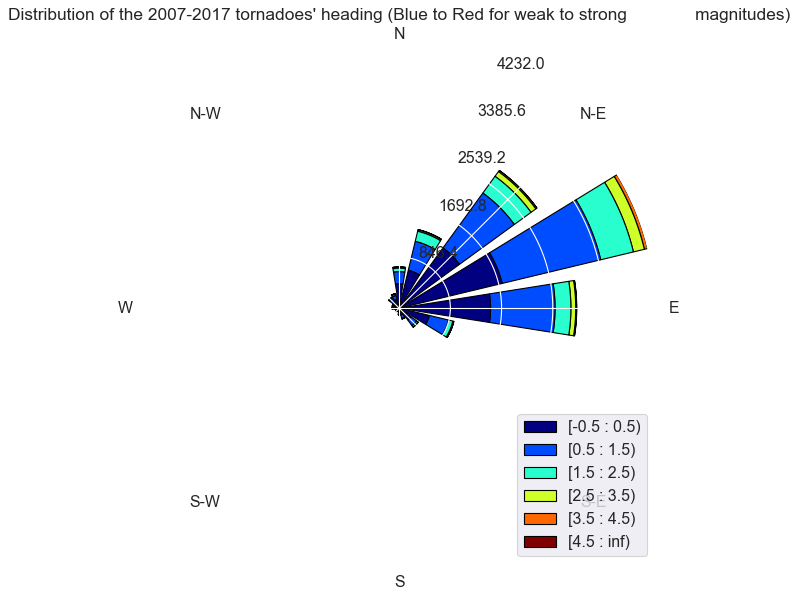

The median azimuth of the tornados' straight paths is:
We are replacing the computed NaN azimuths to this value.
nPlot after imputing NaN azimuth values:


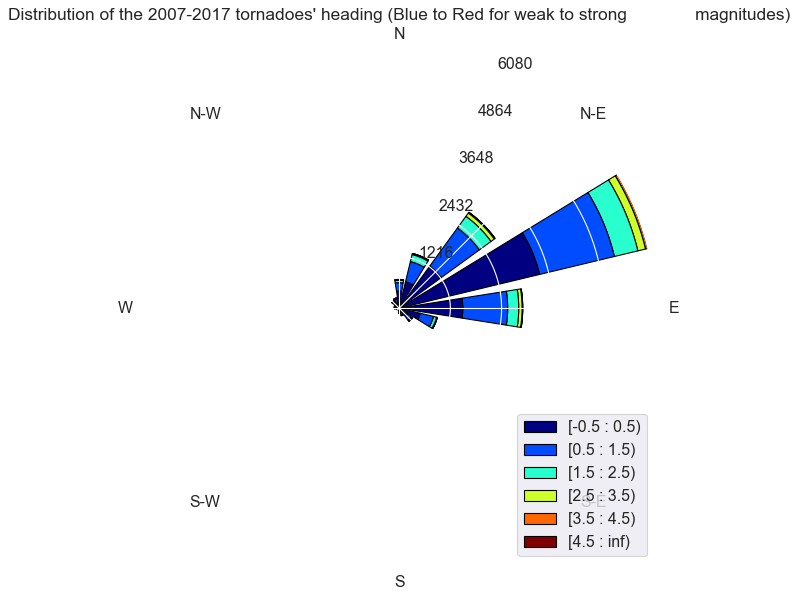

In [71]:
# Plots the windrose before imputing values for stationary tornadoes:
print("Plot before imputing NaN azimuth values:")
plot_windrose(tornado_2007_2017)

# Filling the azimuth NaN values with median:
print("The median azimuth of the tornados' straight paths is:"), \
      tornado_2007_2017['Azimuth'].median(), "degrees."
print("We are replacing the computed NaN azimuths to this value.")
tornado_2007_2017.Azimuth.fillna(tornado_2007_2017['Azimuth'].median(), inplace=True)

# Plots the windrose after imputing values for stationary tornadoes:
print("nPlot after imputing NaN azimuth values:")
plot_windrose(tornado_2007_2017)

# Converting the state FIPS numbers into state abbreviations easily recognizable:
tornado_2007_2017['State'] = tornado_2007_2017['STATE_FIPS'].map(lambda x: fips_to_state[x])

# Removing columns related to location:
tornado_2007_2017.drop(['BEGIN_RANGE', 'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH', 
                        'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 
                        'CZ_NAME', 'CZ_TYPE', 'CZ_FIPS', 'WFO', 'STATE_FIPS', 'STATE', 
                        'BEGIN_LOCATION', 'END_LOCATION', 
                        'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
                        'TOR_OTHER_WFO'],
                       axis=1, inplace=True)

# Converting the cost columns into integer numbers:
tornado_2007_2017['PropertyDamageCost'] = \
tornado_2007_2017.DAMAGE_PROPERTY.map(convertcost_tointeger)
tornado_2007_2017['CropsDamageCost'] = tornado_2007_2017.DAMAGE_CROPS.map(convertcost_tointeger)

# Removing old columns related to costs:
tornado_2007_2017.drop(['DAMAGE_PROPERTY', 'DAMAGE_CROPS'], axis=1, inplace=True)

# Replacing spaces by underscores in the SOURCE feature:
tornado_2007_2017.SOURCE = tornado_2007_2017.SOURCE.map(lambda x: x.replace(' ', '_'))

# Removing tornado with outlier TOR_LENGTH=100:
tornado_2007_2017 = tornado_2007_2017[tornado_2007_2017.TOR_LENGTH<50]



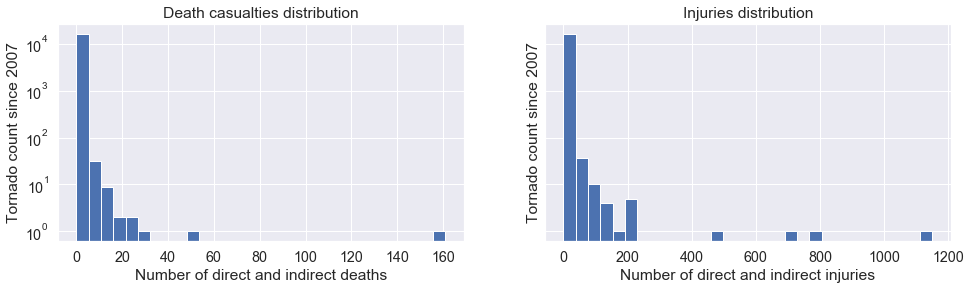

In [72]:
# Checking death casualties and injuries, taking both direct and indirect ones together:
fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
tornado_2007_2017.Deaths.hist(bins=30, log=True, ax=ax[0])
tornado_2007_2017.Injuries.hist(bins=30, log=True, ax=ax[1])
ax[0].set_title("Death casualties distribution")
ax[0].set_xlabel("Number of direct and indirect deaths")
ax[0].set_ylabel("Tornado count since 2007")
ax[1].set_title("Injuries distribution")
ax[1].set_xlabel("Number of direct and indirect injuries")
ax[1].set_ylabel("Tornado count since 2007")
plt.show()

In [73]:
y1 = tornado_2007_2017.reset_index().TOR_F_SCALE
X1 = tornado_2007_2017.reset_index().drop(['TOR_F_SCALE'], axis=1)

In [94]:
tornado_2007_2017.to_csv(r'Resources/CleanTornado2.csv')

In [74]:
# Standardizing numerical features:
numfeat = ['TOR_LENGTH', 'TOR_WIDTH', 'Duration', 'AverageDate', 'AverageTime', 
           'Deaths', 'Injuries', 'Mean_Lat', 'Mean_Lon', 'Azimuth']
scaler = StandardScaler()
X1numfeat = pd.DataFrame(scaler.fit_transform(X1[numfeat]), columns=numfeat)
X1numfeat.head(2)

,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth
0,-0.384696,-0.453753,-0.372725,-0.399389,0.034001,-0.046745,-0.057794,0.025597,-0.818166,-1.299679
1,-0.396503,-0.557985,-0.080881,0.326020,0.391832,-0.046745,-0.057794,-2.195896,1.453279,-1.324643


In [75]:
# Checking which State we will drop after dummification (the most common one should be dropped):
tornado_2007_2017.State.value_counts().head(2)

TX    1551
KS    1227
Name: State, dtype: int64

In [76]:
# Checking which Source we will drop after dummification (the most common one should be dropped):
tornado_2007_2017.SOURCE.value_counts().head(2)

NWS_Storm_Survey    10349
Trained_Spotter      1167
Name: SOURCE, dtype: int64

In [77]:
X1dums = pd.get_dummies(X1[['State','SOURCE']], prefix=['State','Source'],
                        columns=['State','SOURCE'])
X1dums.drop(['State_TX','Source_NWS_Storm_Survey'], axis=1, inplace=True)
X1dums.head(2)

,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,...,Source_Official_NWS_Observations,Source_Other_Federal_Agency,Source_Park/Forest_Service,Source_Public,Source_Social_Media,Source_State_Official,Source_Storm_Chaser,Source_Trained_Spotter,Source_Unknown,Source_Utility_Company
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# Putting back together the standardized and dummifies features:
X1 = pd.concat([X1numfeat,X1dums], axis=1)
print(X1.shape, X1numfeat.shape, X1dums.shape)
X1.head(2)

(16353, 86) (16353, 10) (16353, 76)


,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,...,Source_Official_NWS_Observations,Source_Other_Federal_Agency,Source_Park/Forest_Service,Source_Public,Source_Social_Media,Source_State_Official,Source_Storm_Chaser,Source_Trained_Spotter,Source_Unknown,Source_Utility_Company
0,-0.384696,-0.453753,-0.372725,-0.399389,0.034001,-0.046745,-0.057794,0.025597,-0.818166,-1.299679,...,0,0,0,0,0,0,0,0,0,0
1,-0.396503,-0.557985,-0.080881,0.326020,0.391832,-0.046745,-0.057794,-2.195896,1.453279,-1.324643,...,0,0,0,0,0,0,0,0,0,0


In [79]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y1, test_size=0.3, 
                                                    stratify=y1, random_state=31)

In [80]:
ytest1.value_counts()

EF0    2585
EF1    1642
EF2     475
EF3     134
EFU      35
EF4      31
EF5       4
Name: TOR_F_SCALE, dtype: int64

In [81]:
ytest_valcounts = ytest1.value_counts()
accuracy_baseline = ytest_valcounts.get_values()[0]/float(ytest_valcounts.get_values().sum())
print("Accuracy | Test\t\t | Baseline\t\t | EF0 tornados:\t", round(accuracy_baseline, 3))

Accuracy | Test		 | Baseline		 | EF0 tornados:	 0.527


In [82]:
#LOGISTIC REGRESSION
lr1 = LogisticRegression()
accuracy_cv5_lr1 = np.mean(cross_val_score(lr1, Xtrain1, ytrain1, cv=5))
print("Accuracy | Train CV5\t | Logistic Regresssion\t | Default params:\t", round(accuracy_cv5_lr1, 3))

Accuracy | Train CV5	 | Logistic Regresssion	 | Default params:	 0.669


In [83]:
lr1.fit(Xtrain1, ytrain1)
yhat1_lr1 = lr1.predict(Xtest1)
accuracy_lr1 = accuracy_score(ytest1, yhat1_lr1)
print("Accuracy | Test\t\t | Logistic Regresssion\t | Default params:\t", round(accuracy_lr1, 3))

Accuracy | Test		 | Logistic Regresssion	 | Default params:	 0.671


In [84]:
#OPTIMIZATION
params_logreg_v1 = {'penalty': ['l1','l2'], 'C':np.logspace(2,6,5)}
lr2 = GridSearchCV(lr1, param_grid=params_logreg_v1, cv=5)
lr2.fit(Xtrain1, ytrain1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
lr2.best_params_

{'C': 1000.0, 'penalty': 'l1'}

In [38]:
print ("Accuracy | Train CV5\t | Logistic Regresssion\t | Optimal params:\t", round(lr2.best_score_, 3))

Accuracy | Train CV5	 | Logistic Regresssion	 | Optimal params:	 0.67


In [39]:
lr3 = lr2.best_estimator_.fit(Xtrain1, ytrain1)
yhat1_lr3 = lr3.predict(Xtest1)
accuracy_lr3 = accuracy_score(ytest1, yhat1_lr3)
print("Accuracy | Test\t\t | Logistic Regresssion\t | Optimal params:\t", round(accuracy_lr3, 3))

Accuracy | Test		 | Logistic Regresssion	 | Optimal params:	 0.671


In [40]:
#RANDOM FOREST 
rf1 = RandomForestClassifier(random_state=31)
accuracy_cv5_rf1 = np.mean(cross_val_score(rf1, Xtrain1, ytrain1, cv=5))
print(round(accuracy_cv5_rf1, 3))

# rf = RandomForestClassifier(n_estimators=200)
# rf = rf.fit(iris.data, iris.target)
# rf.score(iris.data, iris.target)

0.676


In [41]:
rf1.fit(Xtrain1, ytrain1)
yhat1_rf1 = rf1.predict(Xtest1)
accuracy_rf1 = accuracy_score(ytest1, yhat1_rf1)
print("Accuracy | Test\t\t | Random Forest\t | Default params:\t", round(accuracy_rf1, 3))

Accuracy | Test		 | Random Forest	 | Default params:	 0.679


In [42]:
#USING BASE PARAMATERS 
rf2 = RandomForestClassifier(criterion='gini', max_depth=7, max_features=0.7, min_samples_leaf=1,
                             min_samples_split=5, n_estimators=24, random_state=31)
rf2.fit(Xtrain1, ytrain1)
yhat1_rf2 = rf2.predict(Xtest1)
accuracy_rf2 = accuracy_score(ytest1, yhat1_rf2)
print("Accuracy | Test\t\t | Random Forest\t | Part2 params:\t\t", round(accuracy_rf2, 3))

Accuracy | Test		 | Random Forest	 | Part2 params:		 0.699


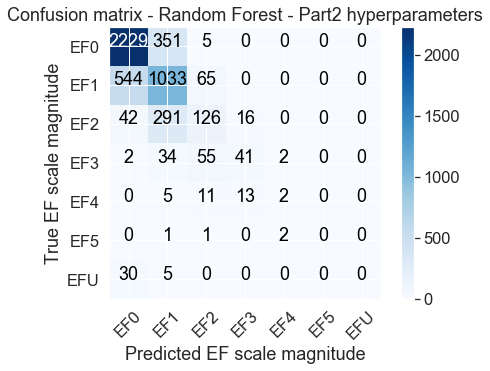

In [85]:
# Computing the confusion matrix
confmatrix_rf2 = confusion_matrix(ytest1, rf2.predict(Xtest1))

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmatrix_rf2, rf2.classes_,
                      'Confusion matrix - Random Forest - Part2 hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

In [86]:
params_randfor_v1 = {'criterion': ['gini','entropy'],
                     'max_depth': [10,15],
                     'max_features': [0.4,0.6,0.8],
                     'n_estimators': [20, 40, 60, 80],
                     'min_samples_split': [6, 10, 14],
                     'min_samples_leaf': [1,2]
                    }

rf3 = GridSearchCV(rf1, param_grid=params_randfor_v1, cv=5, verbose=1, n_jobs=2)
rf3.fit(Xtrain1, ytrain1)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 11.9min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 20.8min
[Parallel(n_jobs=2)]: Done 1440 out of 1440 | elapsed: 25.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=31, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 15], 'max_features': [0.4, 0.6, 0.8], 'n_estimators': [20, 40, 60, 80], 'min_samples_split': [6, 10, 14], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [87]:
rf3.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 0.8,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 40}

In [88]:
print("Accuracy | Train CV5\t | Random Forest\t | Optimal params:\t", round(rf3.best_score_, 3))

Accuracy | Train CV5	 | Random Forest	 | Optimal params:	 0.702


In [89]:
rf4 = rf3.best_estimator_
rf4.fit(Xtrain1, ytrain1)

yhat1_rf4 = rf4.predict(Xtest1)
accuracy_rf4 = accuracy_score(ytest1, yhat1_rf4)
print("Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf4, 3))

Accuracy | Test		 | Random Forest	 | Optimized params:	 0.704


In [90]:
params_randfor_v2 = {'criterion': ['entropy'],
                     'max_depth': [16,18,20],
                     'max_features': [0.3,0.4,0.5],
                     'n_estimators': [68,70,72],
                     'min_samples_split': [8,9,10],
                     'min_samples_leaf': [1]
                    }

rf5 = GridSearchCV(rf1, param_grid=params_randfor_v2, cv=5, verbose=1, n_jobs=2)
rf5.fit(Xtrain1, ytrain1)

print("\nBest params:", rf5.best_params_)

print("\nAccuracy | Train CV5\t | Random Forest\t | Optimal params:\t", round(rf5.best_score_, 3))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  9.7min finished



Best params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 68}

Accuracy | Train CV5	 | Random Forest	 | Optimal params:	 0.703


In [91]:
# First time use after gridsearch: rf6 = rf5.best_estimator_
# Not to have to rerun the gridsearch again:
rf6 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9, 
                             n_estimators=72, random_state=31)
rf6.fit(Xtrain1, ytrain1)

yhat1_rf6 = rf6.predict(Xtest1)
accuracy_rf6 = accuracy_score(ytest1, yhat1_rf6)
print("Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf6, 3))

Accuracy | Test		 | Random Forest	 | Optimized params:	 0.706


In [ ]:
# Computing the confusion matrix
confmatrix_rf6 = confusion_matrix(ytest1, rf6.predict(Xtest1))

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmatrix_rf6, rf6.classes_,
                      'Confusion matrix - Random Forest - Optimized hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

In [ ]:
# Creating a DF out of the coefficients, and sorting them in order of importance of 
# their absolute value:
importanceDF_rf6 = pd.DataFrame({'Importances': rf6.feature_importances_},
                          index = Xtrain1.columns)
importanceDF_rf6.T

In [ ]:
# Most important features:
mostimp_rf6 = importanceDF_rf6.sort_values(by="Importances", ascending=False)
mostimp_rf6.head(3)

In [ ]:
# Horizontal bar plot


Neural Network 

In [ ]:
X2 = X1numfeat.copy()
print(X2.shape)

In [ ]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y1, test_size=0.3, 
                                                    stratify=y1, random_state=31)

In [ ]:
# Same parameters as the best one we obtained:
lr4 = LogisticRegression(penalty='l2', C=1000000)
accuracy_cv5_lr4 = np.mean(cross_val_score(lr4, Xtrain2, ytrain2, cv=5))
print ("Accuracy | Train CV5\t | Logistic Regresssion\t | Default params\t | No dummies:\t"), round(accuracy_cv5_lr4, 3)

In [ ]:

lr4.fit(Xtrain2, ytrain2)
yhat2_lr4 = lr4.predict(Xtest2)
accuracy_lr4 = accuracy_score(ytest2, yhat2_lr4)
print ("Accuracy | Test\t\t | Logistic Regresssion\t | Default params\t | No dummies:\t"), round(accuracy_lr4, 3)

In [ ]:
# Same parameters as the best one we obtained:
rf7 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9,
                             n_estimators=72, random_state=31)
accuracy_cv5_rf7 = np.mean(cross_val_score(rf7, Xtrain2, ytrain2, cv=5))
print ("Accuracy | Train CV5\t | Random Forest\t | Default params\t | No dummies:\t"), round(accuracy_cv5_rf7, 3)

In [ ]:
rf7.fit(Xtrain2, ytrain2)
yhat2_rf7 = rf7.predict(Xtest2)
accuracy_rf7 = accuracy_score(ytest2, yhat2_rf7)
print ("Accuracy | Test\t\t | Random Forest\t | Default params\t | No dummies:\t"), round(accuracy_rf7, 3)

In [ ]:
#X2.reset_index(drop=True, inplace=True)
np.random.seed(7)
# create model
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(np.array(Xtrain2),
          np.array(ytrain2.map(convertEFtonb)),
          epochs=150, batch_size=10)

In [ ]:
# Predictions on the test set:
yhat2_rnn1 = model.predict(np.array(Xtest2))
len(yhat2_rnn1)

In [ ]:
ytest2array = np.array(ytest2.map(convertEFtonb))
ytest2array.shape

In [ ]:
yhat2_rnn1trans = np.empty_like(ytest2array)
for i in range(len(yhat2_rnn1)):
    yhat2_rnn1trans[i] = int(round(float(yhat2_rnn1[i])))

yhat2_rnn1trans.shape

In [ ]:
accuracy_rnn1 = accuracy_score(ytest2array, yhat2_rnn1trans)
print ("Accuracy | Test\t\t | Logistic Regresssion\t\t | Default params\t | No dummies:\t"), round(accuracy_lr1, 3)
print ("Accuracy | Test\t\t | Random Forest\t\t | Default params\t | No dummies:\t"), round(accuracy_rf7, 3)
print ("Accuracy | Test\t\t | Recursive Neural Network\t | Test params:\t\t\t"), round(accuracy_rnn1, 3)

In [ ]:
Time Series analysis

sql_query = """
SELECT *
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
LIMIT 2
"""
pd.read_sql(sql_query, engine_local)

In [ ]:
# Checking that from 2007 we only have EF scale data:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
LIMIT 3
"""
pd.read_sql(sql_query, engine_local)

In [ ]:
sql_query = """
SELECT "BEGIN_YEARMONTH", COUNT("BEGIN_YEARMONTH") as "COUNTTORNADOES"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "BEGIN_YEARMONTH"
ORDER BY "BEGIN_YEARMONTH" ASC
"""
count_per_month = pd.read_sql(sql_query, engine_local)
print (count_per_month.shape)
count_per_month.head(2)

In [ ]:
count_per_month.info()

In [ ]:
count_per_month['YearMonth'] = count_per_month['BEGIN_YEARMONTH']\
                               .map(lambda x: str(x)[:4]+'-'+str(x)[4:]+'-15')
count_per_month.drop(['BEGIN_YEARMONTH'], axis=1, inplace=True)
count_per_month['YearMonth'] = pd.to_datetime(count_per_month['YearMonth'])
count_per_month.set_index(['YearMonth'], inplace=True)
count_per_month.index.name = None